In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import cho_factor, cho_solve
from scipy.stats import weightedtau

from scripts.utils import listfiles
from subprocess import *

%matplotlib inline

In [2]:
dataDirectory = "../data/" #.dat files
testsDirectory = "tests/" #.in files
completeTestsDirectory = "tests/test_completos/" #.in files
nuestrosTestsDirectory = "nuestrosTests/" #.in files

figOutputDirectory = "../informe/imagenes/"

executable = "./tp"

# Elo
TODO: mover a un .py

In [11]:
# implementando elo
# https://www.geeksforgeeks.org/elo-rating-algorithm/


def ELOProbability(rating1, rating2): 
    return 1.0 * 1.0 / (1 + 1.0 * math.pow(10, 1.0 * (rating1 - rating2) / 400)) 

def ELORating(Ra, Rb, d):

    K = 30

    Pb = ELOProbability(Ra, Rb)
    Pa = ELOProbability(Rb, Ra)

    # gana A
    if (d == 1) :
        Ra = Ra + K * (1 - Pa)
        Rb = Rb + K * (0 - Pb)
    # gana B
    else :
        Ra = Ra + K * (0 - Pa)
        Rb = Rb + K * (1 - Pb)

    return (round(Ra, 6), round(Rb, 6))

In [13]:
# generando dataframe para el ranking utilizando elo

table_names=['date', 'eq1', 'sc1', 'eq2', 'sc2']
nba_df = pd.read_table("../data/nba_2016_scores.dat", delimiter=' ', names=table_names)[1:]

nba_teams = pd.concat([nba_df.eq1, nba_df.eq2], axis=0).unique()
elo_rating = np.repeat(1500, len(nba_teams))

elo_df = pd.DataFrame(data={'id': nba_teams, 'elo': elo_rating})

for i, row in nba_df.iterrows():
    elo_eq1 = elo_df[elo_df.id==row.eq1].elo.iloc[0]
    elo_eq2 = elo_df[elo_df.id==row.eq2].elo.iloc[0]

    (elo_eq1, elo_eq2) = ELORating(elo_eq1, elo_eq2, row.sc1)

    elo_df.at[elo_df.id==row.eq1, "elo"] = elo_eq1
    elo_df.at[elo_df.id==row.eq2, "elo"] = elo_eq2

In [35]:
# generar csv para cmm y wp
columnas = ['id', 'CMM', 'ganados', 'perdidos', 'jugados']

!python metnum.py build;
!./tp ../data/nba_2016_scores.dat ../data/nba_2016_scores_CMM.out 0 ../data/nba_2016_scores_CMM.csv
!./tp ../data/nba_2016_scores.dat ../data/nba_2016_scores_WP.out 1 ../data/nba_2016_scores_WP.csv

resultados = pd.DataFrame()

cmm_df = pd.read_csv("../data/nba_2016_scores_CMM.csv").rename({'rating': 'CMM'}, axis=1)
resultados = cmm_df[['id', 'ganados', 'perdidos', 'jugados', 'CMM']].set_index("id")
wp_df = pd.read_csv("../data/nba_2016_scores_WP.csv")[['id', 'rating']].rename({'rating': 'WP'}, axis=1)

resultados = resultados.join(wp_df.set_index("id"), on="id").join(elo_df.set_index("id"), on="id")
        
resultados

,ganados,perdidos,jugados,CMM,WP,elo
id,,,,,,
9,34,33,67,0.500250,0.507463,1509.652976
1,38,29,67,0.558822,0.567164,1446.297082
5,33,32,65,0.516007,0.507692,1526.533743
6,47,19,66,0.692428,0.712121,1359.110354
10,60,6,66,0.874063,0.909091,1201.383591
19,24,42,66,0.384521,0.363636,1585.759328
30,31,35,66,0.483709,0.469697,1528.224601
22,29,37,66,0.432244,0.439394,1577.794607
2,39,28,67,0.565690,0.582090,1427.090923


In [36]:
teams = pd.read_csv(dataDirectory + "nba_2016_teams.csv", names = ['id', 'name']).set_index('id')

teams = teams.join(resultados, on="id") #agrego los ratings
teams.dropna(subset=['CMM'], inplace=True) #drop todos los que no tienen CMM (i.e. no jugaron)

cmm_sorted = teams.sort_values('CMM', ascending = False).reset_index()
cmm_sorted.head(10)

,id,name,ganados,perdidos,jugados,CMM,WP,elo
0,10,Golden_State,60,6,66,0.874063,0.909091,1201.383591
1,27,San_Antonio,57,10,67,0.803976,0.850746,1235.366702
2,6,Cleveland,47,19,66,0.692428,0.712121,1359.110354
3,28,Toronto,45,21,66,0.659347,0.681818,1361.395639
4,21,Oklahoma_City,45,22,67,0.655552,0.671642,1396.907543
5,13,LA_Clippers,42,24,66,0.629708,0.636364,1406.491540
6,16,Miami,39,28,67,0.577367,0.582090,1431.914656
7,2,Boston,39,28,67,0.565690,0.582090,1427.090923
8,15,Memphis,39,28,67,0.563176,0.582090,1468.690288
9,1,Atlanta,38,29,67,0.558822,0.567164,1446.297082


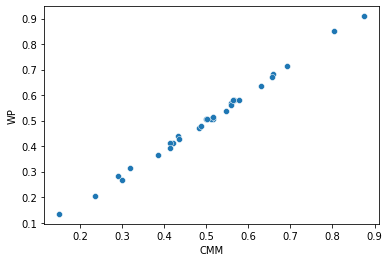

In [41]:
sns.scatterplot(x=resultados['CMM'], y=resultados['WP'])
plt.savefig(f"{figOutputDirectory}scatterplot_nba_CMM_WP.png")

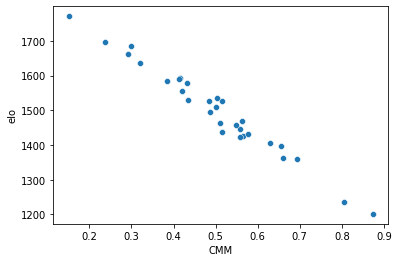

In [42]:
sns.scatterplot(x=resultados['CMM'], y=resultados['elo'])
plt.savefig(f"{figOutputDirectory}scatterplot_nba_CMM_Elo.png")

In [39]:
resultados[['CMM', 'WP', 'elo']].corr()

,CMM,WP,elo
CMM,1.000000,0.998542,-0.986527
WP,0.998542,1.000000,-0.985564
elo,-0.986527,-0.985564,1.000000


In [40]:
print("CMM vs WP: ", weightedtau(x=resultados['CMM'], y=resultados['WP']))
print("CMM vs Elo: ", weightedtau(x=resultados['CMM'], y=resultados['elo']))

CMM vs WP:  WeightedTauResult(correlation=0.9891771102334314, pvalue=nan)
CMM vs Elo:  WeightedTauResult(correlation=-0.932533588617648, pvalue=nan)


In [43]:
import itertools
def findsubsets(S,m):
    return set(itertools.combinations(S, m))

In [67]:
all_ids = set(resultados.index.unique())

jugaronTodos = True

for eq1, eq2 in findsubsets(all_ids, 2):
    jugaronTodos = jugaronTodos and not nba_df[(nba_df.eq1 == 1) & (nba_df.eq2 == 2)].empty
    
jugaronTodos

True

In [71]:
for eq in all_ids:
    print(f"eq {eq} jugo {len(nba_df[(nba_df.eq1 == eq) | (nba_df.eq2 == eq)])}")

eq 1 jugo 67
eq 2 jugo 67
eq 3 jugo 67
eq 4 jugo 66
eq 5 jugo 65
eq 6 jugo 66
eq 7 jugo 67
eq 8 jugo 68
eq 9 jugo 67
eq 10 jugo 66
eq 11 jugo 67
eq 12 jugo 67
eq 13 jugo 66
eq 14 jugo 68
eq 15 jugo 67
eq 16 jugo 67
eq 17 jugo 68
eq 18 jugo 67
eq 19 jugo 66
eq 20 jugo 68
eq 21 jugo 67
eq 22 jugo 66
eq 23 jugo 67
eq 24 jugo 67
eq 25 jugo 68
eq 26 jugo 66
eq 27 jugo 67
eq 28 jugo 66
eq 29 jugo 67
eq 30 jugo 66
